# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
names = []
with open('datasets/russian_names.txt', 'r', encoding='utf-8') as input_file:
    for line in input_file:
        names.append(' ' + line.strip())

In [3]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

Посмотрим на распределение длин имен:

(array([1.000e+00, 5.300e+01, 1.590e+02, 0.000e+00, 6.110e+02, 1.213e+03,
        1.730e+03, 0.000e+00, 1.847e+03, 1.614e+03, 0.000e+00, 1.142e+03,
        5.870e+02, 2.700e+02, 0.000e+00, 1.030e+02, 3.800e+01, 0.000e+00,
        8.000e+00, 5.000e+00, 2.300e+01, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00]),
 array([ 3.  ,  3.72,  4.44,  5.16,  5.88,  6.6 ,  7.32,  8.04,  8.76,
         9.48, 10.2 , 10.92, 11.64, 12.36, 13.08, 13.8 , 14.52, 15.24,
        15.96, 16.68, 17.4 , 18.12, 18.84, 19.56, 20.28, 21.  ]),
 <BarContainer object of 25 artists>)

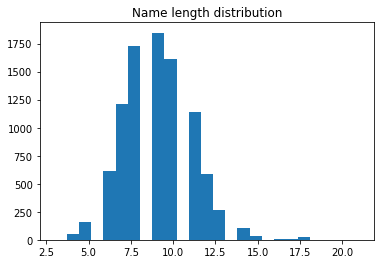

In [4]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25)

# Препроцессинг

In [5]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens =', num_tokens)

num_tokens = 52


### Символы -> id

Создадим словарь < символ > -> < id >

In [6]:
token2id = {token: idx for idx, token in enumerate(tokens)}

In [7]:
assert len(tokens) == len(token2id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token2id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [8]:
def to_matrix(data, token2id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_idx = np.zeros((len(data), max_len), dtype=dtype) + token2id[' ']

    for i, item in enumerate(data):
        line_idx = [token2id[c] for c in item]
        data_idx[i, :len(line_idx)] = line_idx
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_idx = np.transpose(data_idx)

    return data_idx

In [9]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
matrix = to_matrix(names[::2000], token2id)
print(matrix)

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[16  2 38 51 38 29 28 16 16 16]
 [16 39 46 14 46 51 36 46 12  0]
 [16 40 35 51 14 29 28  0 16 16]
 [16  1 51 29 46 51 44 29 14 43]
 [16 20 35  6 12 43 29 28 16 16]]


# Рекуррентные нейронные сети

<img src="img/rnn.png" width=480>

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [11]:
NUM_TOKENS = len(tokens)
EMB_SIZE = 16
RNN_UNITS = 64

In [12]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=NUM_TOKENS, embedding_size=EMB_SIZE, rnn_num_units=RNN_UNITS):
        super(CharRNNCell, self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h) #YOUR CODE HERE
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

### Тренировка сети, RNN loop

In [13]:
def rnn_loop(rnn, batch_index):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_index.size()
    hid_state = rnn.initial_state(batch_size)
    logprobs = []
   
    for x_t in batch_index.transpose(0, 1):
        hid_state, logp_next = rnn(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [14]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

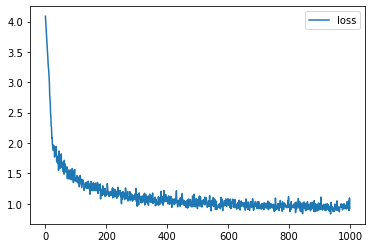

In [15]:
MAX_LENGTH = max(map(len, names))

char_rnn.train()

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), token2id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:, :, None]))###YOUR CODE
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [16]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_rnn.eval()
    
    with torch.no_grad():
        x_sequence = [token2id[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        hid_state = char_rnn.initial_state(batch_size=1)

        #feed the seed phrase, if any
        for i in range(len(seed_phrase) - 1):
            hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

        #start generating
        for _ in range(max_length - len(seed_phrase)):
            hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [17]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.5).strip())

Bakhehev
Vasssky
Kalin
Zharov
Eserer
Balin
Arolarov
Mudelev
Minkin
Bakhov


In [18]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Ef'))

 Efshev              
 Efeban              
 Efrstkamov          
 Efridov             
 Effatev             
 Efdarov             
 Efjhchaky           
 Efddshroff          
 Efylssitov          
 Efuskichik          


### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [21]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=NUM_TOKENS, emb_size=16, rnn_num_units=64):
        super(CharRNNLoop, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        x_emb = self.emb(x)
        output, _ = self.rnn(x_emb)
        next_logits = self.hid_to_logits(output)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

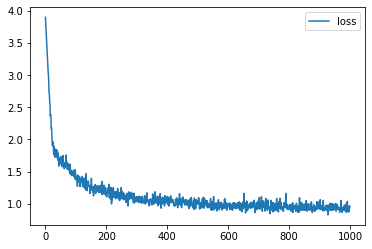

In [22]:
MAX_LENGTH = max(map(len, names))
BATCH_SIZE = 32
EPOCH_NUM = 1000

model.train()

for epoch in range(EPOCH_NUM):
    batch_ix = to_matrix(sample(names, BATCH_SIZE), token2id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    # compute loss
    logp_seq = model(batch_ix)
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = F.nll_loss(predictions_logp.contiguous().view(-1, NUM_TOKENS),
                     actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (epoch + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [23]:
def generate_sample(rnn_model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    rnn_model.eval()
    
    with torch.no_grad():
        x_sequence = [token2id[token] for token in seed_phrase]
        x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
        
        #start generating
        for _ in range(max_length - len(seed_phrase)):
            x_sequence = torch.unsqueeze(x_sequence, 0)
            logp_next = rnn_model(x_sequence[:, -1])
            p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][-1]

            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.squeeze(x_sequence, 0)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [24]:
for _ in range(10):
    print(generate_sample(model, temperature=0.5).strip())

Dalin
Dakhatov
Movenit
Bakhan
Malyanin
Miev
Mozhenko
Jilinov
Yaerdov
Barov


### Генерация цитат: BPE-токенизация + LSTM

In [1]:
import os
import re
from random import sample, shuffle

from tqdm.notebook import tqdm
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from transformers import BertTokenizer

In [2]:
class QuoteDataset:
    def __init__(self, args=None,
                 pretrained_model='bert-base-cased',
                 file_path='datasets/author_quotes.txt',
                 val_size=0.2,
                 batch_size=32):
        if args is not None:
            self.args = vars(args)
        if not args:
            self.args = dict(pretrained_model=pretrained_model, file_path=file_path,
                             val_size=val_size, batch_size=batch_size)
            
        # Forming the vocabulary
        self.tokenizer = BertTokenizer.from_pretrained(self.args['pretrained_model'])
        self.vocab, tokenized_data = self.preprocess_data()
        self.vocab_size = len(self.vocab)
        self.max_seq_len = max(map(len, tokenized_data))
        self.token2id = {token: _id for _id, token in enumerate(self.vocab)}
        self.id2token = {_id: token for _id, token in enumerate(self.vocab)}
        
        # Forming the train/val data loaders
        indexed_data = self.to_matrix(tokenized_data)
        np.random.shuffle(indexed_data)
        train_val_bound = int(indexed_data.shape[0] * self.args['val_size'])
        kwargs = self.make_kwargs()
        train_set = indexed_data[train_val_bound:]
        train = self.to_input_target(train_set)
        self.train_loader = DataLoader(train, batch_size=self.args['batch_size'], shuffle=True, **kwargs)
        val_set = indexed_data[:train_val_bound]
        val = self.to_input_target(val_set)
        self.val_loader = DataLoader(val, batch_size=self.args['batch_size'], shuffle=True, **kwargs)
        
        
    @staticmethod
    def clean_text(_text):
        _text = re.sub("\n|(</?[^>]*>)", " ", _text)
        _text = re.sub(r"\s+", " ", _text)
        return _text.strip()
    
    def preprocess_data(self):
        token_set = set()
        tokenized_quotes = []
        
        with open(self.args['file_path'], 'r', encoding='utf-8') as infile:
            for line in infile:
                line = self.clean_text(line)
                tokenized_quote = self.tokenizer.tokenize(line)
                tokenized_quote = ['[CLS]'] + tokenized_quote + ['[SEP]']
                tokenized_quotes.append(tokenized_quote)
                token_set.update(set(tokenized_quote))
                
        num_samples = len(tokenized_quotes) // self.args['batch_size'] * self.args['batch_size']
        shuffle(tokenized_quotes)
        return ['[PAD]'] + list(token_set), tokenized_quotes[:num_samples]
    
    def to_matrix(self, data, _dtype='int32', batch_first=True):
        indexed_data = np.zeros((len(data), self.max_seq_len), dtype=_dtype)
        
        for i, item in enumerate(data):
            token_ids = [self.token2id[token] for token in item]
            indexed_data[i, :len(token_ids)] = token_ids
            
        if not batch_first:
            indexed_data = np.transpose(indexed_data)
            
        return indexed_data
    
    @staticmethod
    def to_input_target(init_data):
        _input = torch.tensor(init_data, dtype=torch.int64)
        _target = _input[:, 1:]
        return TensorDataset(_input, _target)
    
    @staticmethod
    def make_kwargs():
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")
        kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
        return kwargs

In [3]:
class LSTMGen(nn.Module):
    def __init__(self, vocab_size, emb_size=128, lstm_size=128, layers=3):
        super(LSTMGen, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.lstm_size = lstm_size
        self.num_layers = layers
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                embedding_dim=emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_size,
                            num_layers=layers, batch_first=True, dropout=0.2)
        self.logits = nn.Linear(in_features=lstm_size,
                                out_features=vocab_size)
        
    def forward(self, _input, prev_state):
        input_emb = self.embedding(_input)
        output, h_state = self.lstm(input_emb, prev_state)
        logits = self.logits(output)
        p_logits = F.log_softmax(logits, dim=-1)
        return p_logits, h_state
    
    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size, requires_grad=True),
                torch.zeros(self.num_layers, batch_size, self.lstm_size, requires_grad=True))

In [4]:
class QuoteGenerator:
    def __init__(self):
        self.dataset = QuoteDataset()
        self.generator = LSTMGen(self.dataset.vocab_size)
        self.optimizer = Adam(self.generator.parameters(), lr=0.001)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        print("Model configuration parameters")
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Vocabulary size:", self.generator.vocab_size)
        print("Embedding size:", self.generator.emb_size)
        print("LSTM hidden size:", self.generator.lstm_size)
        print("Number of recurrent layers:", self.generator.num_layers)
        print("Used device:", self.device.type)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        
    def train(self, epoch_num, log_interval=10):
        self.generator.to(self.device)
        self.generator.train()
        
        for epoch in tqdm(range(epoch_num), total=epoch_num):
            epoch_loss = []
            h_state, c_state = self.generator.init_state(self.dataset.args['batch_size'])
            h_state, c_state = h_state.to(self.device), c_state.to(self.device)
            
            for batch, (_input, _target) in enumerate(self.dataset.train_loader):
                _input, _target = _input.to(self.device), _target.to(self.device)
                
                predicted, (h_state, c_state) = self.generator(_input, (h_state, c_state))
                predicted = predicted[:, :-1]
                loss = F.nll_loss(predicted.contiguous().view(-1, self.dataset.vocab_size),
                                  _target.contiguous().view(-1))
                
                h_state = h_state.detach()
                c_state = c_state.detach()
                
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
                epoch_loss.append(loss.cpu().data.numpy())
                
            if (epoch + 1) % log_interval == 0 or epoch == 0:
                mean_epoch_loss = sum(epoch_loss) / len(epoch_loss)
                print("Epoch #{epoch_num}\nMean epoch loss: {mean_loss}".format(epoch_num=epoch + 1,
                                                                                mean_loss=mean_epoch_loss))
                
    def generate_sample(self, seed_phrase='', temperature=1.0):
        self.generator.to(torch.device("cpu"))
        self.generator.eval()
        
        seed_words = ['[CLS]'] + self.dataset.tokenizer.tokenize(seed_phrase)
        
        with torch.no_grad():
            x_sequence = [self.dataset.token2id[token] for token in seed_words]
            x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
            h_state, c_state = self.generator.init_state(batch_size=1)
            
            # feeding the seed tokens
            for i in range(1, len(seed_words) - 1):
                _, (h_state, c_state) = self.generator(x_sequence[:, :i], (h_state, c_state))

            #start generating
            for _ in range(self.dataset.max_seq_len - len(seed_words)):
                logp_next, (h_state, c_state) = self.generator(x_sequence, (h_state, c_state))
                p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0][-1]

                # sample next token and push it back into x_sequence
                next_ix = np.argmax(p_next)
                next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
                x_sequence = torch.cat([x_sequence, next_ix], dim=1)
                
        tokens = [self.dataset.id2token[_id] for _id in x_sequence.data.numpy()[0]]
        return tokens
    
    @staticmethod
    def pretty_output(raw_tokens):
        _text = ' '.join(raw_tokens)
        _text = re.sub(r'\[.+?\]', '', _text).strip()
        _text = re.sub(r"\s'\s", "'", _text)
        _text = re.sub(r"\s\.", ".", _text)
        _text = re.sub(r"\s\?", "?", _text)

        punkts = [',', '!', ':', ';']
        for symb in punkts:
            _text = re.sub('\s{symbol}'.format(symbol=symb), symb, _text)

        return _text.strip()

In [5]:
generator = QuoteGenerator()
generator.train(1000, log_interval=50)

Model configuration parameters
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Vocabulary size: 19613
Embedding size: 128
LSTM hidden size: 128
Number of recurrent layers: 3
Used device: cuda
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch #1
Mean epoch loss: 2.2799958391527158
Epoch #50
Mean epoch loss: 1.069851469940844
Epoch #100
Mean epoch loss: 0.9786607588814423
Epoch #150
Mean epoch loss: 0.9350937220506963
Epoch #200
Mean epoch loss: 0.9100279958374733
Epoch #250
Mean epoch loss: 0.892855482027594
Epoch #300
Mean epoch loss: 0.8810398325455927
Epoch #350
Mean epoch loss: 0.8725432301253344
Epoch #400
Mean epoch loss: 0.8651479938257057
Epoch #450
Mean epoch loss: 0.8608487358531066
Epoch #500
Mean epoch loss: 0.8561702802513553
Epoch #550
Mean epoch loss: 0.8516953847313349
Epoch #600
Mean epoch loss: 0.8511008634108358
Epoch #650
Mean epoch loss: 0.8477188140417622
Epoch #700
Mean epoch loss: 0.8446618382514051
Epoch #750
Mean epoch loss: 0.8455440800274368
Epoch #800
Mean epoch loss: 0.842500772953561
Epoch #850
Mean epoch loss: 0.8408451289993472
Epoch #900
Mean epoch loss: 0.8407604087111169
Epoch #950
Mean epoch loss: 0.8414061067510495
Epoch #1000
Mean epoch loss: 0.8394232716708057


In [6]:
raw_sample = generator.generate_sample()
sample = generator.pretty_output(raw_sample)
print(sample)

The world of the financial society.


In [7]:
raw_sample = generator.generate_sample(seed_phrase="If you're")
sample = generator.pretty_output(raw_sample)
print(sample)

If you're not going to be 51, you're not going to be a celebrity.
